In [1]:
# Download subset of COCO Dataset
!pip install fiftyone
import fiftyone as fo
import fiftyone.zoo as foz

foz.load_zoo_dataset(
    "coco-2017",
    splits=["validation","train"],
    classes=["person", "car"],
    max_samples=100,
)

     |████████████████████████████████| 1.2 MB 6.6 MB/s 
     |████████████████████████████████| 557 kB 20.1 MB/s 
     |████████████████████████████████| 13.2 MB 142 kB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 47.6 MB 33 kB/s 
     |████████████████████████████████| 79.9 MB 37 kB/s 
     |████████████████████████████████| 131 kB 62.5 MB/s 
     |████████████████████████████████| 29.2 MB 25 kB/s 
     |████████████████████████████████| 631 kB 64.0 MB/s 
     |████████████████████████████████| 225 kB 59.7 MB/s 
     |████████████████████████████████| 106 kB 54.3 MB/s 
     |████████████████████████████████| 82 kB 651 kB/s 
     |████████████████████████████████| 58 kB 5.0 MB/s 
     |████████████████████████████████| 78 kB 6.1 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 8.1 MB 46.6 MB/s 
     |████████████████████████

Name:        coco-2017-validation-train-100
Media type:  image
Num samples: 200
Persistent:  False
Tags:        ['train', 'validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [2]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-wwsgko56
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-wwsgko56
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263920 sha256=5a310e491c9e364499c341ee294973b5aeb8b0514b79587cdb440c496f5794aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-bzq39yo5/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [3]:
# Import useful libraries
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import numpy as np

from torchvision import datasets, models, transforms
import time

import matplotlib
from matplotlib import pyplot as plt

import cv2
import copy
from pycocotools import mask as coco_mask

In [4]:
# Define Useful Functions
def plot_hist(hist, num_epochs=50):
  ohist = [h.detach().cpu().numpy() for h in hist]
  plt.title("Validation Accuracy vs. Number of Training Epochs")
  plt.xlabel("Training Epochs")
  plt.ylabel("Validation Accuracy")
  plt.plot(range(1,num_epochs+1),ohist,label="Trained")
  plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  plt.show()
  
def show_img(img):
  plt.imshow(torchvision.transforms.ToPILImage()(img.squeeze()))

def convert_coco_poly_to_mask(segmentations, height, width):
  masks = []
  for polygons in segmentations:
    rles = coco_mask.frPyObjects(polygons, height, width)
    mask = coco_mask.decode(rles)
    if len(mask.shape) < 3:
      mask = mask[..., None]
    mask = torch.as_tensor(mask, dtype=torch.uint8)
    mask = mask.any(dim=2)
    masks.append(mask)
  if masks:
    masks = torch.stack(masks, dim=0)
  else:
    masks = torch.zeros((0, height, width), dtype=torch.uint8)
  return masks


class ConvertCocoPolysToMask(object):
  def __call__(self, image, anno):
    w, h = image.size
    segmentations = [obj["segmentation"] for obj in anno]
    cats = [obj["category_id"] for obj in anno]
    if segmentations:
      masks = convert_coco_poly_to_mask(segmentations, h, w)
      cats = torch.as_tensor(cats, dtype=masks.dtype)
      # merge all instance masks into a single segmentation map
      # with its corresponding categories
      target, _ = (masks * cats[:, None, None]).max(dim=0)
      # discard overlapping instances
      target[masks.sum(0) > 1] = 255
    else:
      target = torch.zeros((h, w), dtype=torch.uint8)
    #target = Image.fromarray(target.numpy())
    return image, target

In [5]:
# Define Dataset Class
class myOwnDataset(torch.utils.data.Dataset):
  def __init__(self, root, annotation, transforms=None):
    self.root = root
    self.transforms = transforms()
    self.coco = COCO(annotation)
    self.ids = list(sorted(self.coco.imgs.keys()))

  def __getitem__(self, index):
    # Own coco file
    coco = self.coco
    # Image ID
    img_id = self.ids[index]
    # List: get annotation id from coco
    ann_ids = coco.getAnnIds(imgIds=img_id)
    # Dictionary: target coco_annotation file for an image
    coco_annotation = coco.loadAnns(ann_ids)
    # path for input image
    path = coco.loadImgs(img_id)[0]["file_name"]
    # open the input image
    img = Image.open(os.path.join(self.root, path))
    # number of objects in the image
    num_objs = len(coco_annotation)
    width, height = img.size
    segmentations = [obj["segmentation"] for obj in coco_annotation]
    masks = convert_coco_poly_to_mask(segmentations, height, width)
    #print(masks.shape)

    # Bounding boxes for objects
    # In coco format, bbox = [xmin, ymin, width, height]
    # In pytorch, the input should be [xmin, ymin, xmax, ymax]
    boxes = []
    for i in range(num_objs):
      xmin = coco_annotation[i]["bbox"][0]
      ymin = coco_annotation[i]["bbox"][1]
      xmax = xmin + coco_annotation[i]["bbox"][2]
      ymax = ymin + coco_annotation[i]["bbox"][3]
      boxes.append([xmin, ymin, xmax, ymax])
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    if num_objs == 0:
      boxes = torch.arange(0.)
      torch.reshape(boxes, (0, 4))
      print('why')
    # Labels 
    labels = []
    for i in range(num_objs):
      labels.append(coco_annotation[i]["category_id"])
    labels = torch.as_tensor(labels, dtype=torch.int64)
    # Tensorise img_id
    img_id = torch.tensor([img_id], dtype=torch.int64)
    # Size of bbox (Rectangular)
    areas = []
    for i in range(num_objs):
      areas.append(coco_annotation[i]["area"])
    areas = torch.as_tensor(areas, dtype=torch.float32)
    # Iscrowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # Annotation is in dictionary format
    my_annotation = {}
    my_annotation["boxes"] = boxes
    my_annotation["labels"] = labels
    my_annotation["image_id"] = img_id
    my_annotation["area"] = areas
    my_annotation["iscrowd"] = iscrowd
    my_annotation["masks"] = masks
    #my_annotation["new_masks"] = new_masks

    if self.transforms is not None:
      img = self.transforms(img)

    return img, my_annotation

  def __len__(self):
    return len(self.ids)


# In my case, just added ToTensor
def get_transform():
  custom_transforms = []
  custom_transforms.append(torchvision.transforms.ToTensor())
  return torchvision.transforms.Compose(custom_transforms)

# collate_fn needs for batch
def collate_fn(batch):
  return tuple(zip(*batch))

In [6]:
# Define Training Function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
  since = time.time()
  val_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train']:#,'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, annotations in dataloaders[phase]:
        inputs = list(input.to(device) for input in inputs)
        labels = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        #print(labels)
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          if is_inception and phase == 'train':
            # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.5*loss2
          else:
            loss_dict = model(inputs, labels)
            loss = sum(loss_ for loss_ in loss_dict.values())

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss * len(inputs)
        #running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      #if phase == 'val':
      val_acc_history.append(epoch_loss)
      print('{} Loss: {:.4f}'.format(phase, epoch_loss))#, epoch_acc))

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  return model, val_acc_history

In [7]:
# Load Dataset
dataset_train = myOwnDataset(root = '/root/fiftyone/coco-2017/train/data',
                        annotation = '/root/fiftyone/coco-2017/train/labels.json',transforms=get_transform)
dataset_validate = myOwnDataset(root = '/root/fiftyone/coco-2017/validation/data',
                        annotation = '/root/fiftyone/coco-2017/validation/labels.json',transforms=get_transform)

data_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=2, shuffle=True, num_workers=2,
         collate_fn=collate_fn)

data_loader_validate = torch.utils.data.DataLoader(
        dataset_validate, batch_size=2, shuffle=True, num_workers=2,
         collate_fn=collate_fn)

data_loader_dict = {'train': data_loader, 'val': data_loader_validate}

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [8]:
# Download Mask R-CNN Model
model1 = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
model2 = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [9]:
#### if model dict and history not uploaded uncomment out train instruction

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model1 = model1.to(device)
#params_to_update = model1.parameters()
#optimizer1 = optim.SGD(params_to_update, lr=0.005, momentum=0.9, weight_decay=0.0005)
#criterion = nn.CrossEntropyLoss()
#model1, hist1 = train_model(model1, data_loader_dict, criterion, optimizer1, num_epochs=25, is_inception=False)
#model1 = model1.cpu()
#torch.save(model1.state_dict(), 'model1_dict')
model1.load_state_dict(torch.load('/content/model1_dict'))
hist1 = [ 2.0045, 1.9545, 1.9610, 1.8938, 1.8588, 1.8428, 1.7526, 1.6966, 1.6328, 1.6150, 1.5315, 1.5029, 1.4342, 1.4301, 1.3733, 1.3173, 1.3487, 1.2608, 1.1984, 1.1932, 1.1477,  1.0950, 1.0922, 1.0740, 1.0335]


In [10]:
# Define Forward Action of Layer to Add Feature Noise when training through element wise multiplication
class mylayer(nn.Module):
  def __init__(self):
    super(mylayer, self).__init__()
  def forward(self, x):
    if self.training:
      for k, v in x.items():
        a = torch.rand_like(v)*0.4 + 0.8
        x[k] = v * a
    return x

# Combine in sequence with old backbone of model 2
new_backbone = nn.Sequential(
    model2.backbone,
    mylayer()
)
# Replace model2 backbone
model2.backbone = new_backbone

In [11]:
model2

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=1e-05)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=1e-05)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=1e-05)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): Froz

In [12]:
#### if model dict not uploaded uncomment out train instruction
#model2 = model2.to(device)
#params_to_update = model2.parameters()
#optimizer2 = optim.SGD(params_to_update, lr=0.005, momentum=0.9, weight_decay=0.0005)
#criterion = nn.CrossEntropyLoss()
#model2, hist2 = train_model(model2, data_loader_dict, criterion, optimizer2, num_epochs=25, is_inception=False)
#model2 = model2.cpu()
#torch.save(model2.state_dict(), 'model2_dict')
model2.load_state_dict(torch.load('/content/model2_dict'))
hist2 = [ 2.6604, 1.9712, 1.7681, 1.7212, 1.6739, 1.8437, 1.8298, 1.8675, 1.8703, 1.8931, 2.0036, 1.9861, 2.0104, 1.9841, 1.9710, 1.9257, 1.8938, 1.8863, 1.8500, 1.8194, 1.7690, 1.7639, 1.7129, 1.6801, 1.6193]

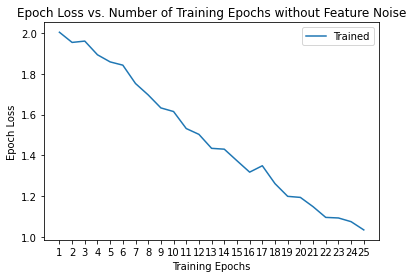

In [13]:
# Define Useful Functions
def plot_hist(hist, num_epochs=50, title="Epoch Loss vs. Number of Training Epochs"):
  ohist = [h.detach().cpu().numpy() if torch.is_tensor(h) else h for h in hist]
  plt.title(title)
  plt.xlabel("Training Epochs")
  plt.ylabel("Epoch Loss")
  plt.plot(range(1,num_epochs+1),ohist,label="Trained")
  #plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  plt.show()
plot_hist(hist1, num_epochs=25, title='Epoch Loss vs. Number of Training Epochs without Feature Noise')

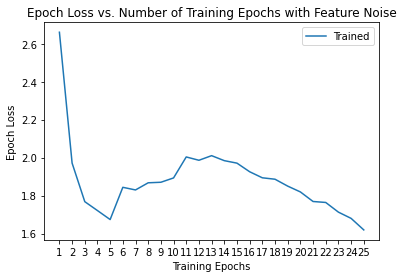

In [14]:
plot_hist(hist2, num_epochs=25, title='Epoch Loss vs. Number of Training Epochs with Feature Noise')

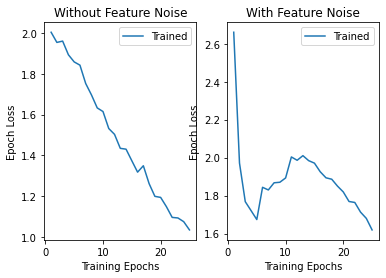

In [16]:
def plot_hist2(hist1, hist2, title1=" ", title2=" ", num_epochs=50):
  ohist1 = [h.detach().cpu().numpy() if torch.is_tensor(h) else h for h in hist1]
  ohist2 = [h.detach().cpu().numpy() if torch.is_tensor(h) else h for h in hist2]
  fig, ax = plt.subplots(1, 2)
  ax[0].set(xlabel="Training Epochs", ylabel="Epoch Loss")
  ax[0].set_title(title1)
  ax[0].plot(range(1,num_epochs+1),ohist1,label="Trained")

  ax[1].set(xlabel="Training Epochs", ylabel="Epoch Loss")
  ax[1].set_title(title2)
  ax[1].plot(range(1,num_epochs+1),ohist2,label="Trained")
  #plt.ylim((0,1.))
  #ax1.xticks(np.arange(1, num_epochs+1, 1.0))
  ax[0].legend()
  ax[1].legend()
  plt.show()

title1 = 'Without Feature Noise'
title2 = 'With Feature Noise'
plot_hist2(hist1, hist2, title1=title1, title2=title2, num_epochs=25)

In [17]:
img, label = next(iter(data_loader_validate))

In [18]:
img1 = img[0].unsqueeze(0)#.shape
model1.eval()
a0 = model1.backbone.forward(img1)
a1 = model2.backbone.forward(img1)
model2.eval()
a2 = model2.backbone.forward(img1)
#model2.backbone.forward(img[0].unsqueeze(0))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0
1
2
3
pool


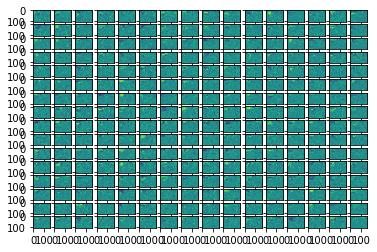

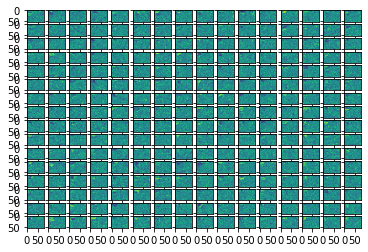

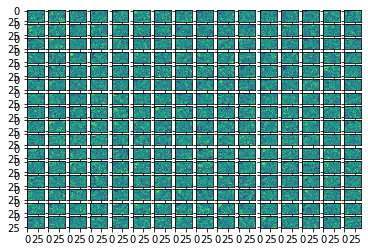

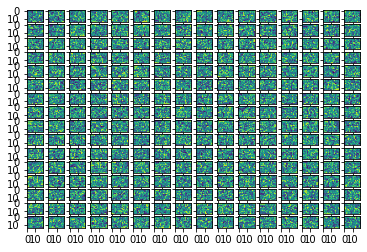

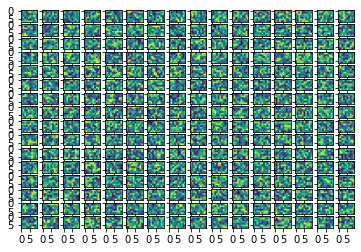

In [43]:
def get_features(a):
  for k,v in a.items():
    print(k)
    v = v.squeeze()
    #show_img(v[1,:,:])
    fig, axs = plt.subplots(16, 16)
    indx = 0
    for i in range(16):
      for j in range(16):
        axs[i,j].imshow(torchvision.transforms.ToPILImage()(v[indx,:,:]))
        indx += 1
    for ax in axs.flat:
      ax.label_outer()

get_features(a0)

0
1
2
3
pool


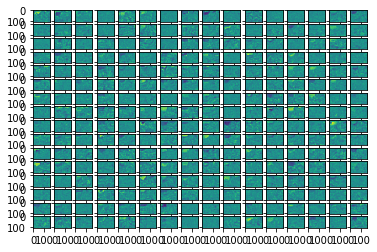

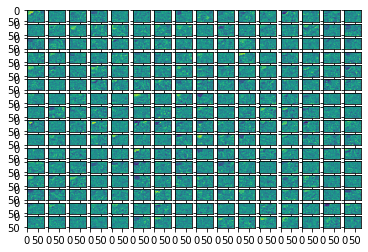

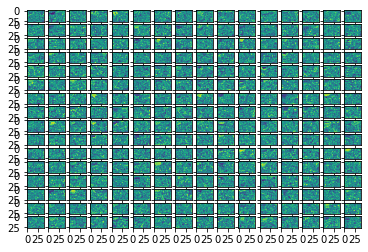

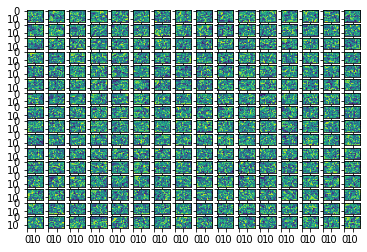

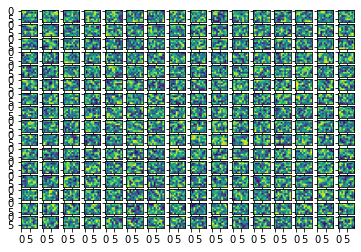

In [44]:
get_features(a1)

0
1
2
3
pool


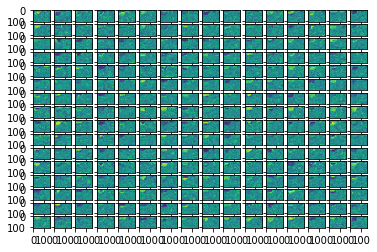

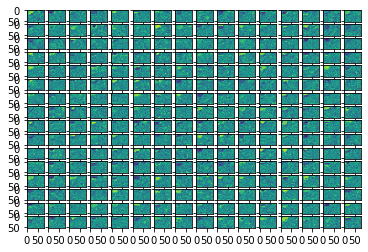

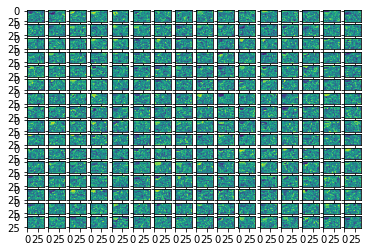

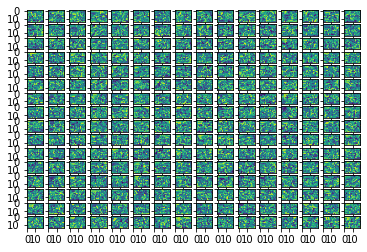

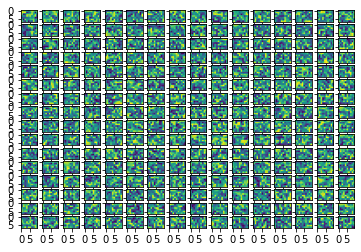

In [45]:
get_features(a2)